### Imports

In [1]:
import os
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 1

%aimport models, train, analysis

In [3]:
from models import MLP_SP
from train import *
from analysis import *

### Hparams

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.backends.mps.is_available() 
                      else "cpu")
# data
BATCH = 128

# experiment
N_TASKS = 10
BLOCKS = 1
EPOCHS_PER_TASK = 1

# models
IN_DIM = 28 * 28
OUT_DIM = 10
HL_DIMS = [128, 128]
CONTEXT_LAYERS_MASK = [1, 1, 1]  # first entrie is for input context

# training
LR = 1e-3

# checkpoints / later analysis
SAVE_ON_TASKS = [0, N_TASKS//2, N_TASKS-1]
CHECKPOINT_DIR = "./models_checkpoints_0"

# seed
SEED = 0

# seed numpy and torch
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


### Data


Image batch shape: torch.Size([128, 1, 28, 28])
Label batch shape: torch.Size([128])
Image datatype: torch.float32
Label datatype: torch.int64
Image value range: -1.0 to 1.0


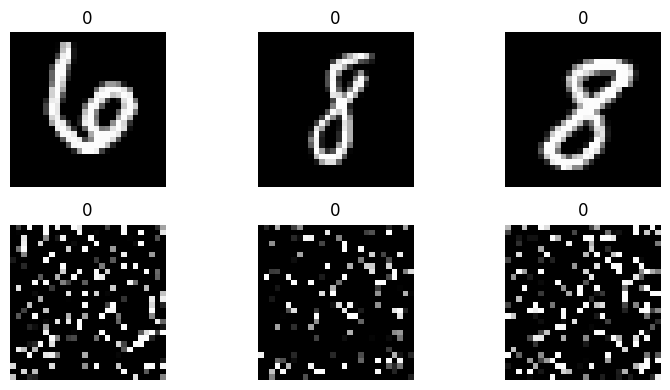

In [5]:
# show some sample images and info of shape and datatype and value range
dataiter = iter(init_dataloader_mnist(BATCH, shuffle=True)[0])
images, labels = next(dataiter)
print(f'Image batch shape: {images.size()}')
print(f'Label batch shape: {labels.size()}')
print(f'Image datatype: {images.dtype}')
print(f'Label datatype: {labels.dtype}')
print(f'Image value range: {images.min().item()} to {images.max().item()}')

n_images = 3
perm_example = torch.randperm(28 * 28)

fig, axes = plt.subplots(2, n_images, figsize=(8, 4))
for i in range(n_images):
    axes[0, i].imshow(images[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f'{labels[i].argmax().item()}')
    axes[0, i].axis('off')

    permuted_image = images[i].view(-1)[perm_example].view(28, 28)
    axes[1, i].imshow(permuted_image.cpu().numpy(), cmap='gray')
    axes[1, i].set_title(f'{labels[i].argmax().item()}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Run Experiments


In [6]:
# partial class constroctor for models
MLP_SP_exp = partial(MLP_SP,
                    input_dim=IN_DIM, output_dim=OUT_DIM, hl_dims=HL_DIMS,
                    num_tasks=N_TASKS,
                    device=DEVICE,
                    context_layers_mask=CONTEXT_LAYERS_MASK)

# criterion
criterion = F.cross_entropy
print(f'start of context vector (contex model): {MLP_SP_exp(use_context=True).get_buffer("context_0")[0][:10]} ...')
print(f'start of context vector (baseline model): {MLP_SP_exp(use_context=False).get_buffer("context_0")[0][:10]} ...')

start of context vector (contex model): tensor([ 1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.]) ...
start of context vector (baseline model): tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) ...


In [7]:
# data loaders
train_loader , test_loader = init_dataloader_mnist(BATCH, shuffle=True) 

# permutations for different tasks
input_permutations = [np.random.permutation(28*28) for _ in range(N_TASKS)]

# set identity permutation for first task
input_permutations[0] = np.arange(28*28) # identity for first task
input_permutations = np.array(input_permutations)

# save permutations to file
np.save('mnist_permutations_0.npy', np.array(input_permutations))

# not necessary, but for convenience, keep everything in torch tensor on DEVICE
# permutation_tensors = torch.tensor(input_permutations, dtype=torch.long, device=DEVICE)

print("Input permutations shape:", input_permutations.shape)
print("first task permutation is identity?", np.array_equal(input_permutations[0], np.arange(input_permutations.shape[1])))

Input permutations shape: (10, 784)
first task permutation is identity? True


In [8]:
run_experiment = partial(run_experiment,
                         criterion=criterion,
                         train_loader=train_loader,
                         test_loader=test_loader,
                         input_permutations=input_permutations,
                         n_tasks=N_TASKS,
                         blocks=BLOCKS,
                         epochs_per_task=EPOCHS_PER_TASK,
                         device=DEVICE,
                         save_on_tasks=SAVE_ON_TASKS,
                         save_dir=CHECKPOINT_DIR,
                         )

In [9]:
# run for context model
model_context = MLP_SP_exp(use_context=True, use_task_ro=False)
optimizer = optim.Adam(model_context.parameters(), lr=LR)
trace_contex = run_experiment(model_context, optimizer)

g_epochs::   0%|          | 0/10 [00:00<?, ?it/s]

(checkpoint) model saved at ./models_checkpoints_0/model_c_task_0_block_0.pth
Acc Task 0: 92.48%, Acc Task current: 92.48% (Block 0, Task 0)
Acc Task 0: 90.99%, Acc Task current: 94.09% (Block 0, Task 1)
Acc Task 0: 88.36%, Acc Task current: 93.71% (Block 0, Task 2)
Acc Task 0: 81.33%, Acc Task current: 93.90% (Block 0, Task 3)
Acc Task 0: 76.47%, Acc Task current: 94.41% (Block 0, Task 4)
(checkpoint) model saved at ./models_checkpoints_0/model_c_task_5_block_0.pth
Acc Task 0: 77.53%, Acc Task current: 95.11% (Block 0, Task 5)
Acc Task 0: 78.06%, Acc Task current: 93.48% (Block 0, Task 6)
Acc Task 0: 74.32%, Acc Task current: 93.70% (Block 0, Task 7)
Acc Task 0: 74.89%, Acc Task current: 94.36% (Block 0, Task 8)
(checkpoint) model saved at ./models_checkpoints_0/model_c_task_9_block_0.pth
Acc Task 0: 73.93%, Acc Task current: 94.88% (Block 0, Task 9)


In [10]:
model_baseline = MLP_SP_exp(use_context=False, use_task_ro=False)
optimizer = optim.Adam(model_baseline.parameters(), lr=LR)
trace_baseline = run_experiment(model_baseline, optimizer)

g_epochs::   0%|          | 0/10 [00:00<?, ?it/s]

(checkpoint) model saved at ./models_checkpoints_0/model_b_task_0_block_0.pth
Acc Task 0: 92.26%, Acc Task current: 92.26% (Block 0, Task 0)
Acc Task 0: 87.92%, Acc Task current: 93.00% (Block 0, Task 1)
Acc Task 0: 83.36%, Acc Task current: 93.54% (Block 0, Task 2)
Acc Task 0: 68.48%, Acc Task current: 93.89% (Block 0, Task 3)
Acc Task 0: 57.05%, Acc Task current: 93.58% (Block 0, Task 4)
(checkpoint) model saved at ./models_checkpoints_0/model_b_task_5_block_0.pth
Acc Task 0: 45.10%, Acc Task current: 93.10% (Block 0, Task 5)
Acc Task 0: 36.12%, Acc Task current: 93.64% (Block 0, Task 6)
Acc Task 0: 20.04%, Acc Task current: 92.49% (Block 0, Task 7)
Acc Task 0: 18.75%, Acc Task current: 93.13% (Block 0, Task 8)
(checkpoint) model saved at ./models_checkpoints_0/model_b_task_9_block_0.pth
Acc Task 0: 18.56%, Acc Task current: 92.77% (Block 0, Task 9)


In [11]:
model_context_tro = MLP_SP_exp(use_context=True, use_task_ro=True)
optimizer = optim.Adam(model_context_tro.parameters(), lr=LR)
trace_contex_tro = run_experiment(model_context_tro, optimizer)

g_epochs::   0%|          | 0/10 [00:00<?, ?it/s]

(checkpoint) model saved at ./models_checkpoints_0/model_c_tro_task_0_block_0.pth
Acc Task 0: 92.49%, Acc Task current: 92.49% (Block 0, Task 0)
Acc Task 0: 92.31%, Acc Task current: 92.97% (Block 0, Task 1)
Acc Task 0: 92.20%, Acc Task current: 92.49% (Block 0, Task 2)
Acc Task 0: 91.34%, Acc Task current: 93.73% (Block 0, Task 3)
Acc Task 0: 89.04%, Acc Task current: 93.53% (Block 0, Task 4)
(checkpoint) model saved at ./models_checkpoints_0/model_c_tro_task_5_block_0.pth
Acc Task 0: 88.89%, Acc Task current: 93.54% (Block 0, Task 5)
Acc Task 0: 87.58%, Acc Task current: 93.11% (Block 0, Task 6)
Acc Task 0: 85.16%, Acc Task current: 94.53% (Block 0, Task 7)
Acc Task 0: 82.97%, Acc Task current: 94.09% (Block 0, Task 8)
(checkpoint) model saved at ./models_checkpoints_0/model_c_tro_task_9_block_0.pth
Acc Task 0: 79.38%, Acc Task current: 93.30% (Block 0, Task 9)


In [12]:
model_baseline_tro = MLP_SP_exp(use_context=False, use_task_ro=True)
optimizer = optim.Adam(model_baseline_tro.parameters(), lr=LR)
trace_baseline_tro = run_experiment(model_baseline_tro, optimizer)

g_epochs::   0%|          | 0/10 [00:00<?, ?it/s]

(checkpoint) model saved at ./models_checkpoints_0/model_b_tro_task_0_block_0.pth
Acc Task 0: 92.65%, Acc Task current: 92.65% (Block 0, Task 0)
Acc Task 0: 64.37%, Acc Task current: 92.72% (Block 0, Task 1)
Acc Task 0: 70.51%, Acc Task current: 92.06% (Block 0, Task 2)
Acc Task 0: 57.59%, Acc Task current: 91.68% (Block 0, Task 3)
Acc Task 0: 52.14%, Acc Task current: 92.08% (Block 0, Task 4)
(checkpoint) model saved at ./models_checkpoints_0/model_b_tro_task_5_block_0.pth
Acc Task 0: 41.33%, Acc Task current: 91.48% (Block 0, Task 5)
Acc Task 0: 28.49%, Acc Task current: 92.89% (Block 0, Task 6)
Acc Task 0: 39.13%, Acc Task current: 91.92% (Block 0, Task 7)
Acc Task 0: 42.84%, Acc Task current: 92.07% (Block 0, Task 8)
(checkpoint) model saved at ./models_checkpoints_0/model_b_tro_task_9_block_0.pth
Acc Task 0: 36.35%, Acc Task current: 93.05% (Block 0, Task 9)


### Results

In [13]:
def add_boundary_lines(axs, B, T, E):
    task_lines = np.arange(0, B * T * E + 1, E)[1:-1]
    block_lines = np.arange(0, B * T * E + 1, T * E)[1:-1]
    for ax in axs:
        for epoch in task_lines:
            ax.axvline(x=epoch, color='gray', linestyle='--', linewidth=1, alpha=0.2)
        for epoch in block_lines:
            ax.axvline(x=epoch, color='black', linestyle='--', linewidth=2, alpha=0.4)


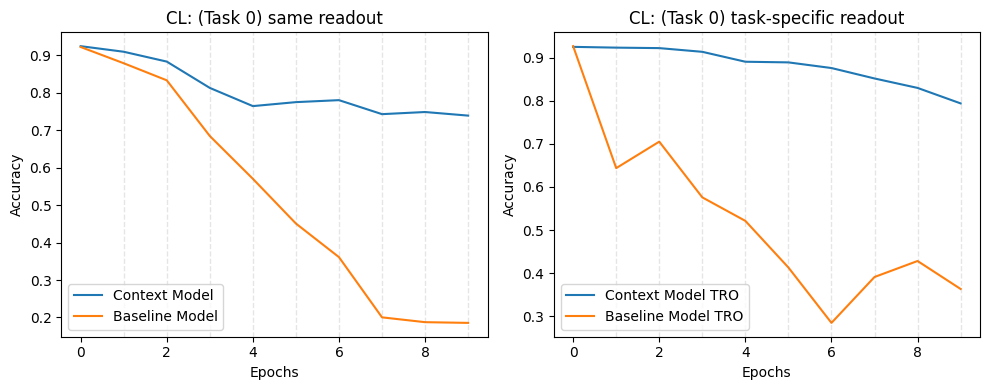

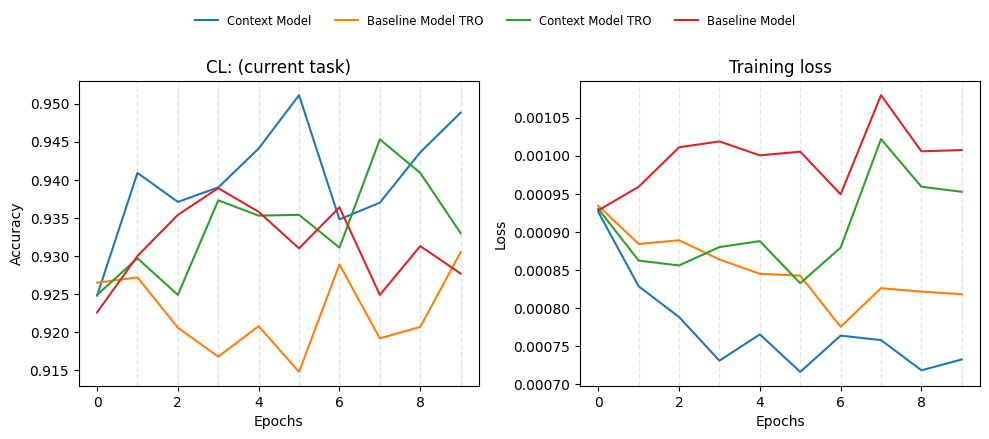

In [14]:
# plot results: accuracy on task 0
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

plot_task_accuracies(trace_contex["accuracy_task_0"], 'Context Model', step=EPOCHS_PER_TASK, ax=axs[0])
plot_task_accuracies(trace_baseline["accuracy_task_0"], 'Baseline Model', step=EPOCHS_PER_TASK, ax=axs[0])

plot_task_accuracies(trace_contex_tro["accuracy_task_0"], 'Context Model TRO', step=EPOCHS_PER_TASK, ax=axs[1])
plot_task_accuracies(trace_baseline_tro["accuracy_task_0"], 'Baseline Model TRO', step=EPOCHS_PER_TASK, ax=axs[1])

axs[0].set_title('CL: (Task 0) same readout')
axs[1].set_title('CL: (Task 0) task-specific readout')

axs[0].legend()
axs[1].legend()

add_boundary_lines(axs, BLOCKS, N_TASKS, EPOCHS_PER_TASK)

plt.tight_layout()
plt.show()

# plot results: loss and accuracy on current task to ensure the models are learning properly on the new tasks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

plot_task_accuracies(trace_contex["accuracy_task_curr"], 'Context Model', step=EPOCHS_PER_TASK, ax=axs[0])
plot_task_accuracies(trace_baseline_tro["accuracy_task_curr"], 'Baseline Model TRO', step=EPOCHS_PER_TASK, ax=axs[0])
plot_task_accuracies(trace_contex_tro["accuracy_task_curr"], 'Context Model TRO', step=EPOCHS_PER_TASK, ax=axs[0])
plot_task_accuracies(trace_baseline["accuracy_task_curr"], 'Baseline Model', step=EPOCHS_PER_TASK,ax=axs[0])

plot_training_loss(trace_contex["loss"], 'Context Model', ax=axs[1])
plot_training_loss(trace_contex_tro["loss"], 'Context Model TRO', ax=axs[1])
plot_training_loss(trace_baseline["loss"], 'Baseline Model', ax=axs[1])
plot_training_loss(trace_baseline_tro["loss"], 'Baseline Model TRO', ax=axs[1])

axs[0].set_title('CL: (current task)')
axs[1].set_title('Training loss')

# add vertical lines at block and task boundaries
add_boundary_lines(axs, BLOCKS, N_TASKS, EPOCHS_PER_TASK)

h, l = axs[0].get_legend_handles_labels()
fig.legend(
    h,
    l,
    loc="upper center",
    ncol=4,
    fontsize="small",
    frameon=False,
    bbox_to_anchor=(0.5, 1.1)
)
plt.tight_layout()
plt.show()


### Analysis

In [15]:
labels = [4, 7]
num_samples_per_label = 15

sub_loaders = {labels[i]: get_subset_of_labels_loader(
        train_loader, allowed_labels=[labels[i]], n_samples_per_label=num_samples_per_label)
        for i in range(len(labels))
        }
print('sub loaders contain:', {key: len(sub_loaders[key].dataset) for key in sub_loaders})

sub loaders contain: {4: 15, 7: 15}


In [ ]:
# load input permutations
input_permutations = np.load('mnist_permutations_0.npy')

# get activations of one model of multiple tasks
mtypes = ['c', 'b', 'c_tro', 'b_tro']


rows = []  # rows for DF
print("loodind models and extracting activations: ")
for m_type in mtypes:
    use_context = True if (m_type == 'c' or m_type == 'c_tro') else False
    use_task_ro = True if (m_type == 'c_tro' or m_type == 'b_tro') else False

    model_loaded = MLP_SP(
        input_dim=IN_DIM,
        output_dim=OUT_DIM,
        hl_dims=HL_DIMS,
        num_tasks=N_TASKS,
        use_context=use_context,      
        use_task_ro=use_task_ro,    
        device=DEVICE,
        context_layers_mask=CONTEXT_LAYERS_MASK,
    )

    for t in SAVE_ON_TASKS:
        path = os.path.join(CHECKPOINT_DIR, f'model_{m_type}_task_{t}_block_0.pth')
        
        state = torch.load(path, map_location=DEVICE)
        model_loaded.load_state_dict(state)
        model_loaded.to(DEVICE)

        act_loaded = get_activations_for_model(
            model_loaded,
            task_id=t,
            block=0,
            input_permutations=input_permutations,
            device=DEVICE,
            sub_loaders=sub_loaders,
        )

        for entry in act_loaded:
            rows.append({
                "model_type": m_type,
                "task_id": entry["task_id"],
                "block": entry["block"],
                "layer": entry["layer"],
                "label": entry["label"],
                "activations": entry["activations"].detach().cpu(),
            })

        acc = evaluate(
            model_loaded,
            test_loader,
            0,
            input_permutations[0],
            device=DEVICE,
        )
        print(f'Model type: {m_type}, Task {t}, Accuracy on test set task 0: {acc:.4f}') 
    print("-"*50)

acts_df = pd.DataFrame(rows)

print("DataFrame shape:", acts_df.shape)
print(acts_df.columns)

loodind models and extracting activations: 
Model type: c, Task 0, Accuracy on test set task 0: 0.9248
Model type: c, Task 5, Accuracy on test set task 0: 0.7753
Model type: c, Task 9, Accuracy on test set task 0: 0.7393
--------------------------------------------------
Model type: b, Task 0, Accuracy on test set task 0: 0.9226
Model type: b, Task 5, Accuracy on test set task 0: 0.4510
Model type: b, Task 9, Accuracy on test set task 0: 0.1856
--------------------------------------------------
Model type: c_tro, Task 0, Accuracy on test set task 0: 0.9249
Model type: c_tro, Task 5, Accuracy on test set task 0: 0.8889
Model type: c_tro, Task 9, Accuracy on test set task 0: 0.7938
--------------------------------------------------
Model type: b_tro, Task 0, Accuracy on test set task 0: 0.9265
Model type: b_tro, Task 5, Accuracy on test set task 0: 0.4133
Model type: b_tro, Task 9, Accuracy on test set task 0: 0.3635
--------------------------------------------------
DataFrame shape: (72

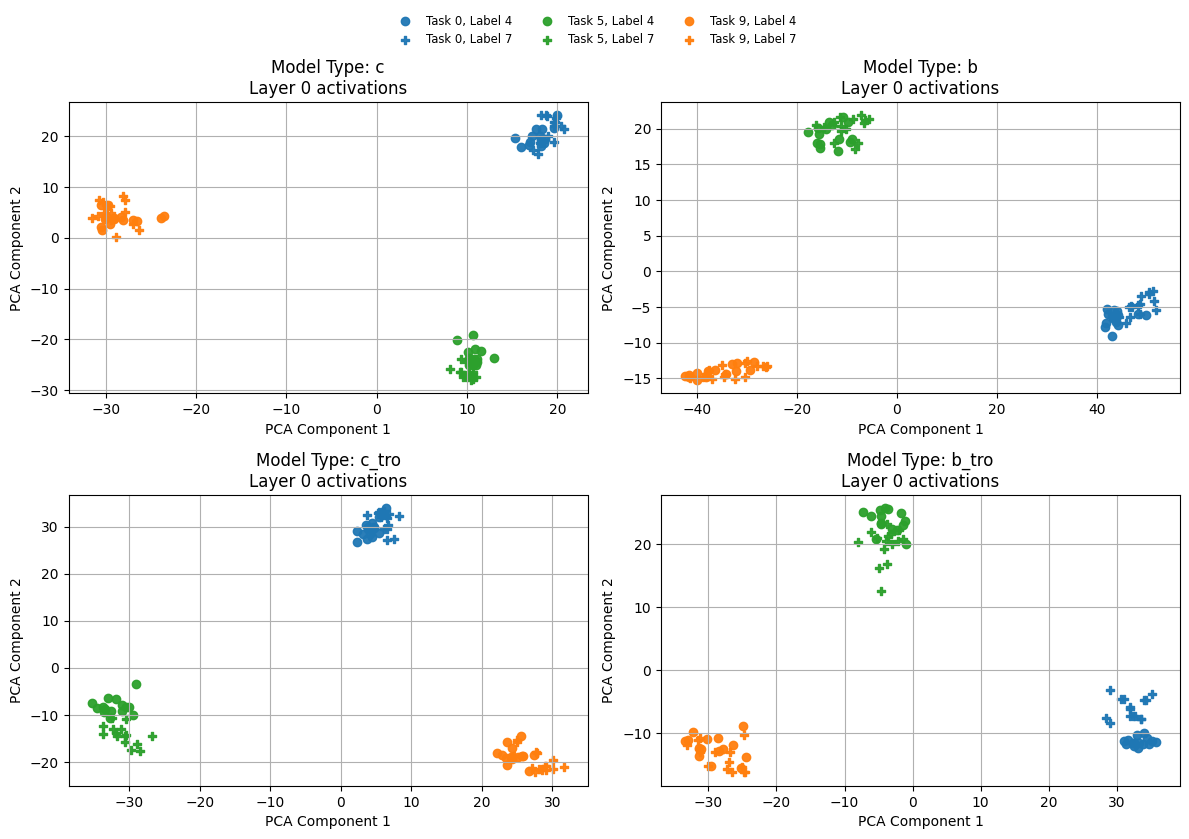

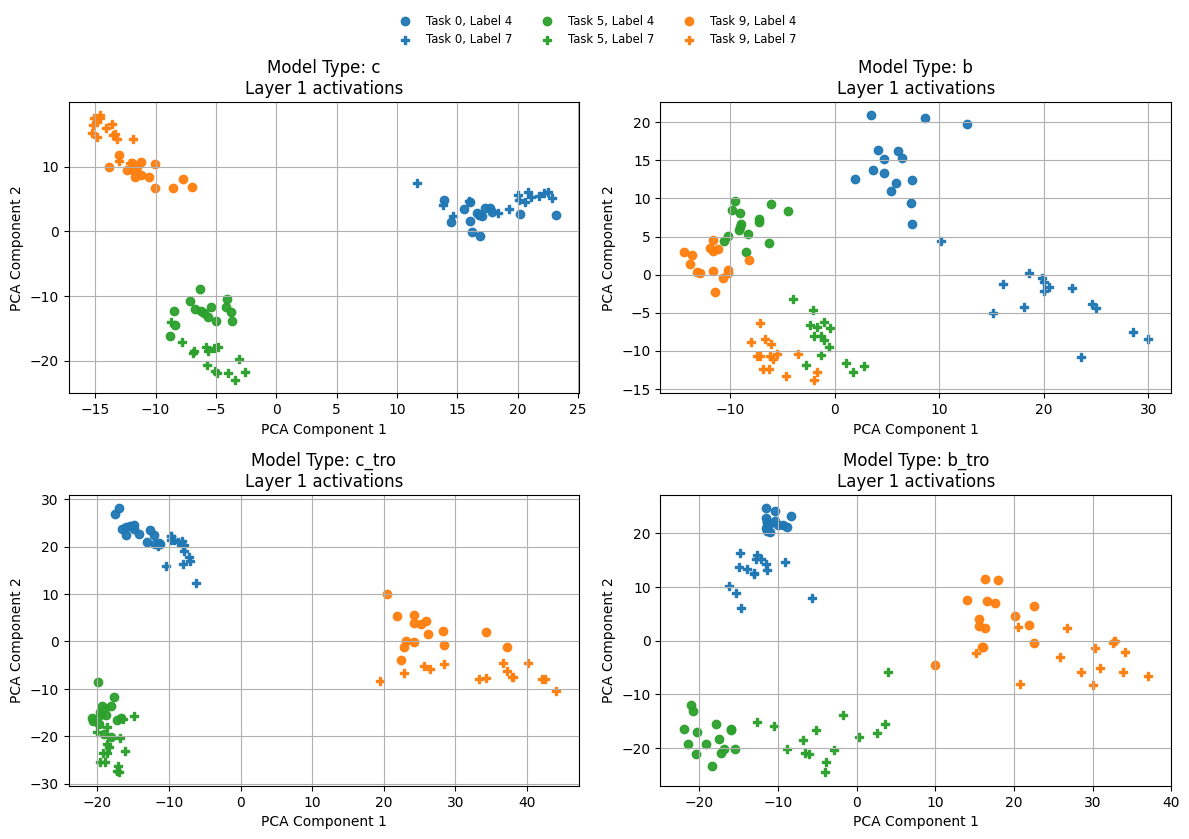

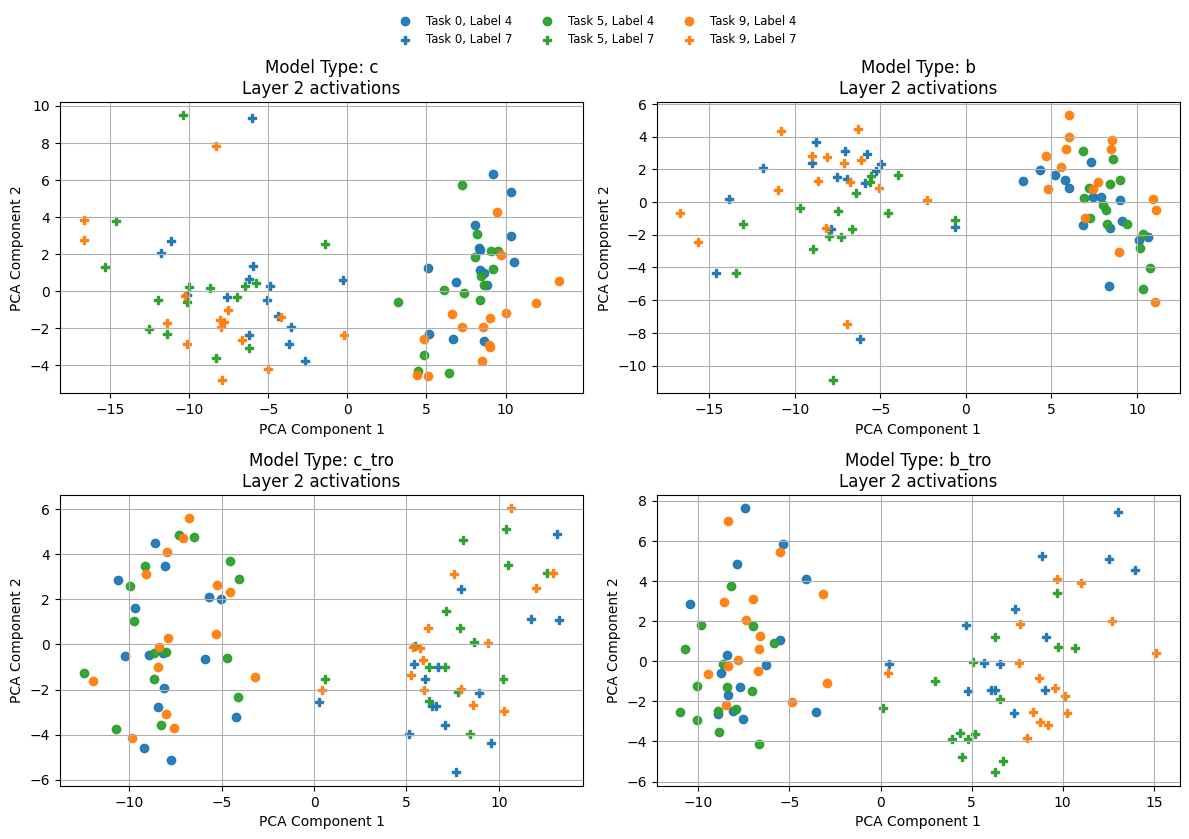

In [17]:
# get PCA of activations from models of a specific layer and tasks, using acts_df
layers_to_analyze = [0, 1, 2]
at_tasks = [0, 5, 9]

for layer_to_analyze in layers_to_analyze:
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    for idx, m_type in enumerate(mtypes):
        # select relevant rows from the DataFrame
        df_m = acts_df.query(
            "model_type == @m_type and layer == @layer_to_analyze and task_id in @at_tasks"
        ).copy()

        # (optional but nice) sort for deterministic ordering in PCA / plotting
        df_m = df_m.sort_values(by=["task_id", "block"])

        #
        act_relevant = [
            {
                "label": row["label"],
                "task_id": row["task_id"],
                "block": row["block"],
                "layer": row["layer"],
                "activations": row["activations"],
            }
            for _, row in df_m.iterrows()
        ]

        # concat into single tensor for PCA
        activations_array = torch.cat(df_m["activations"].tolist(), dim=0).cpu().numpy()

        # get PCA
        activations_pca = get_activations_pca(activations_array, n_pcs=2)

        # plot PCA (same function as before)
        plot_activations_pca(
            act_relevant,
            activations_pca,
            layer_to_analyze,
            ax=axs[idx],
            title=f"Model Type: {m_type}",
        )

    h, l = axs[0].get_legend_handles_labels()
    fig.legend(
        h,
        l,
        loc="upper center",
        ncol=3,
        fontsize="small",
        frameon=False,
        bbox_to_anchor=(0.5, 1.05),
    )

    plt.tight_layout()
    plt.show()


#### Simple RSA on layers of different models (as an example of using rdms and rsa)


In [18]:
def compute_rdm(activations):
    # center each unit
    X = activations - activations.mean(axis=0, keepdims=True)
    # correlation between samples (rows)
    C = np.corrcoef(X)  # shape [N, N]
    RDM = 1.0 - C
    return RDM


def rdm_correlation(rdm1, rdm2):
    assert rdm1.shape == rdm2.shape
    idx = np.triu_indices_from(rdm1, k=1)
    v1 = rdm1[idx]
    v2 = rdm2[idx]

    v1_mean = v1.mean()
    v2_mean = v2.mean()
    num = np.sum((v1 - v1_mean) * (v2 - v2_mean))
    den = np.sqrt(np.sum((v1 - v1_mean) ** 2) * np.sum((v2 - v2_mean) ** 2))
    if den == 0:
        return np.nan
    return num / den

def rsa_between_models(acts_df, m1, m2, at_task, layers_idxs):
    scores = []
    for layer_idx in layers_idxs:
        a1 = acts_df.query(
            "model_type == @m1 and layer == @layer_idx and task_id == @at_task"
        )
        a2 = acts_df.query(
            "model_type == @m2 and layer == @layer_idx and task_id == @at_task"
        )
        # sort
        a1 = a1.sort_values(by=["block"])
        a2 = a2.sort_values(by=["block"])

        arctivations1 = a1["activations"].values
        arctivations2 = a2["activations"].values
        if len(arctivations1) == 0 or len(arctivations2) == 0:
            a1 = None
            a2 = None
        else:
            a1 = torch.cat(arctivations1.tolist(), dim=0).cpu().numpy()
            a2 = torch.cat(arctivations2.tolist(), dim=0).cpu().numpy()


        if a1 is None or a2 is None:
            scores.append(np.nan)
            continue
        rdm1 = compute_rdm(a1)
        rdm2 = compute_rdm(a2)
        score = rdm_correlation(rdm1, rdm2)
        scores.append(score)

    return scores


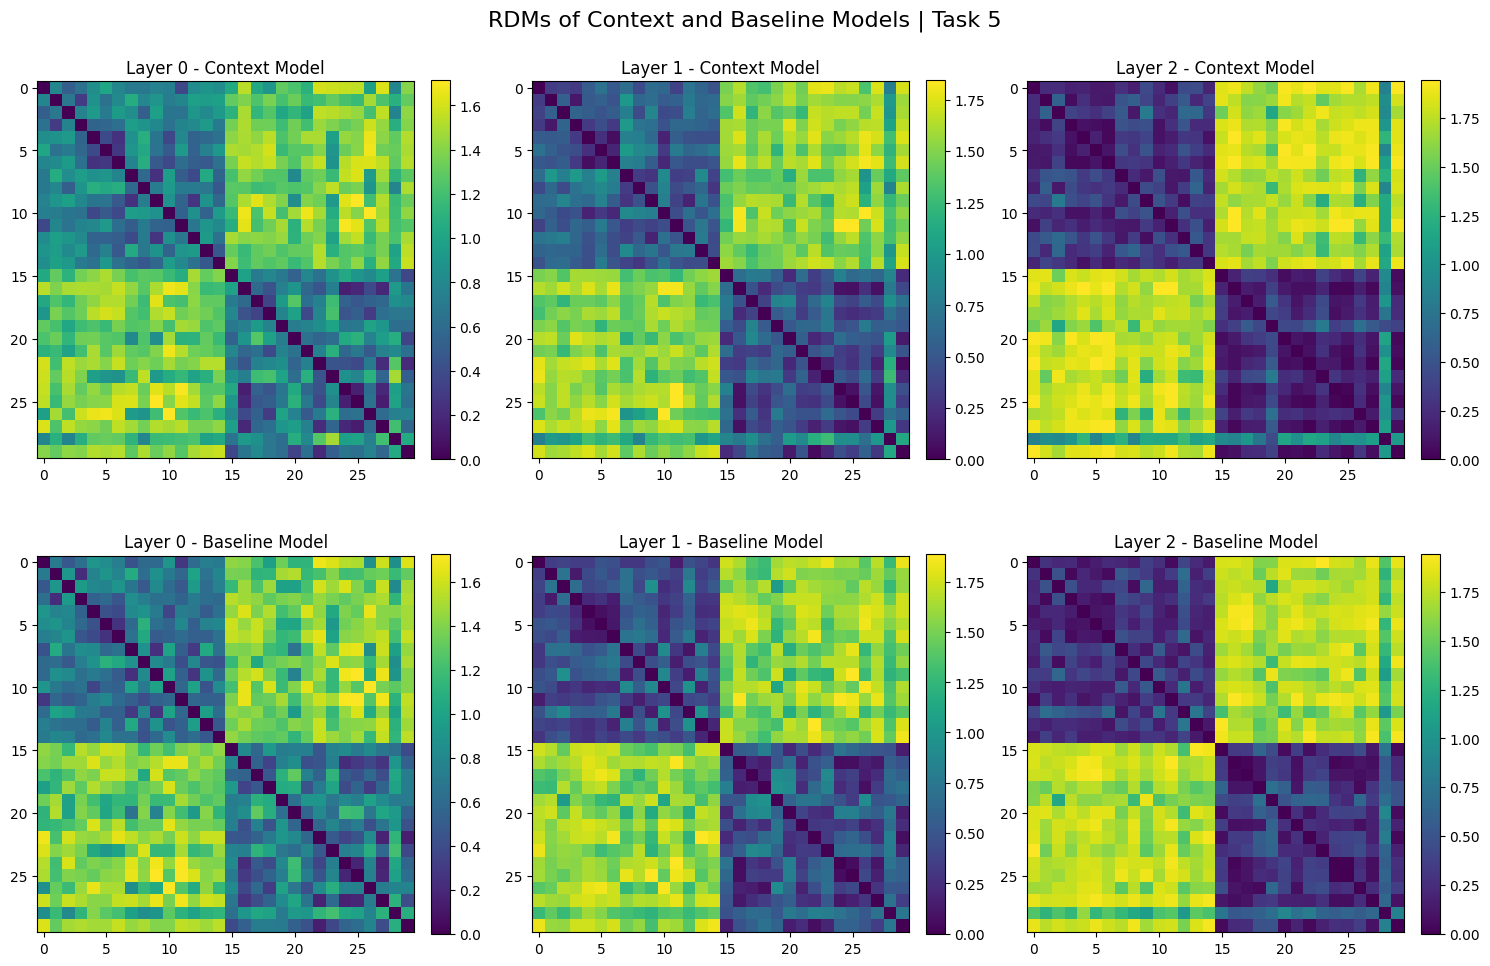

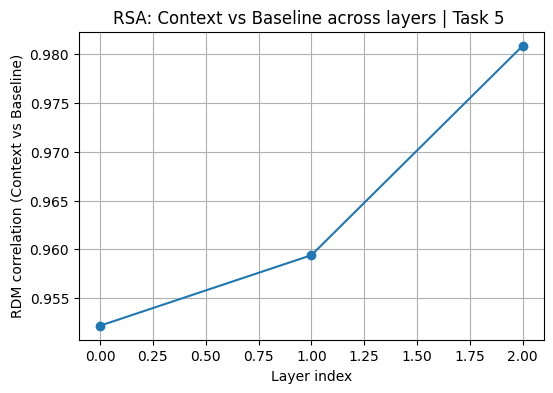

In [19]:
mtypes = ['c', 'b', 'c_tro', 'b_tro']

at_task = 5
layers_idxs = np.arange(len(model_loaded.h_fcs) + 1) 

rsa_scores_cb = []
rdms = {}
for layer_idx in layers_idxs:
    acts_c = acts_df.query(
        "model_type == 'c' and layer == @layer_idx and task_id == @at_task"
    ).copy()
    acts_b = acts_df.query(
        "model_type == 'b' and layer == @layer_idx and task_id == @at_task"
    ).copy()
    # sort
    acts_c = acts_c.sort_values(by=["block"])
    acts_b = acts_b.sort_values(by=["block"])
    
    acts_c = torch.cat(acts_c["activations"].tolist(), dim=0).cpu().numpy()
    acts_b = torch.cat(acts_b["activations"].tolist(), dim=0).cpu().numpy()
    
    if acts_c is None or acts_b is None:
        rsa_scores_cb.append(np.nan)
        continue

    rdm_c = compute_rdm(acts_c)
    rdm_b = compute_rdm(acts_b)
    rdms[layer_idx] = {'context': rdm_c, 'baseline': rdm_b}

    corr = rdm_correlation(rdm_c, rdm_b)
    rsa_scores_cb.append(corr)

# plot rdms of all layers
num_layers = len(layers_idxs)
fig, axs = plt.subplots(2, num_layers, figsize=(5 * num_layers, 10))
fig.suptitle(f"RDMs of Context and Baseline Models | Task {at_task}", fontsize=16)

for layer_idx in layers_idxs:
    rdm_c = rdms[layer_idx]['context']
    rdm_b = rdms[layer_idx]['baseline']

    ax_1, ax_2 = axs[0, layer_idx], axs[1, layer_idx]
    im1 = ax_1.imshow(rdm_c, cmap='viridis')
    ax_1.set_title(f'Layer {layer_idx} - Context Model')
    plt.colorbar(im1, ax=ax_1, fraction=0.046, pad=0.04)
    im2 = ax_2.imshow(rdm_b, cmap='viridis')
    ax_2.set_title(f'Layer {layer_idx} - Baseline Model')
    plt.colorbar(im2, ax=ax_2, fraction=0.046, pad=0.04)    

plt.tight_layout()
plt.show() 

# plot the RSA similarity across layers
plt.figure(figsize=(6,4))
plt.plot(layers_idxs, rsa_scores_cb, marker='o')
plt.xlabel("Layer index")
plt.ylabel("RDM correlation (Context vs Baseline)")
plt.title(f"RSA: Context vs Baseline across layers | Task {at_task} ")
plt.grid(True)
plt.show()


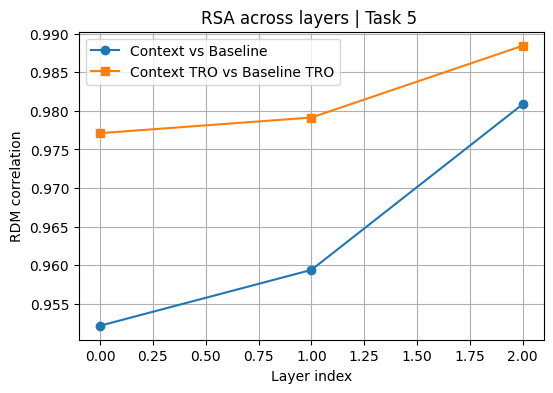

In [20]:
layers_idxs = np.arange(len(model_loaded.h_fcs) + 1)

rsa_cb     = rsa_between_models(acts_df, 'c',     'b',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                at_task, layers_idxs)
rsa_cb_tro = rsa_between_models(acts_df, 'c_tro', 'b_tro', at_task, layers_idxs)

plt.figure(figsize=(6,4))
plt.plot(layers_idxs, rsa_cb,     marker='o', label='Context vs Baseline')
plt.plot(layers_idxs, rsa_cb_tro, marker='s', label='Context TRO vs Baseline TRO')
plt.xlabel("Layer index")
plt.ylabel("RDM correlation")
plt.title(f"RSA across layers | Task {at_task} ")
plt.legend()
plt.grid(True)
plt.show()
